In [1]:
# https://github.com/WackAlley/worksheet/tree/main/labcourse21

In [2]:
import numpy as np
from icecream import ic
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

## Kinetische Impulsbestimmung

Skalierungsfaktor $s_P$
\begin{align}
    s_P &= \frac{L_{1}}{30.01cm} - \frac{1}{30.01cm}\frac{L_{1} - L_{2}}{2} \\
    \Delta s_{P} &= \sqrt{ \left(\frac{\partial s_{P}}{\partial L_{1}} \Delta L_{1}\right)^{2} + 
                           \left(\frac{\partial s_{P}}{\partial L_{2}} \Delta L_{2}\right)^{2}}
\end{align}

Krümmungsradius $r_{real}$ in $cm$
\begin{align}
    r_{real} &= \frac{r_{gemessen}}{s_{P}} \\
    \Delta r_{real} &= \sqrt{ \left( \frac{\partial r_{real}}{\partial r_{gem}} \Delta r_{gem} \right)^2 + \left( \frac{\partial r_{real}}{\partial s_{P}} \Delta s_{P} \right)^2 } \\
                    &= \sqrt{\left(\frac{\Delta r_{gem}}{s_{P}}\right)^2 + \left( \frac{r_{gem}}{s_{P}^2} \Delta s_{P} \right)^2}
\end{align}

Impuls $p$ in $\frac{MeV}{c}$
\begin{align}
    p & = 2.998 \cdot B[T] \cdot r_{real}[cm] \frac{MeV}{c\cdot cm \cdot T} \\
    \Delta p &= \sqrt{ \left( \frac{\partial p}{\partial r_{real}} \Delta r_{real} \right)^2 } \\
             &= \sqrt{2.998 \cdot 2.05 \cdot \Delta r_{real}}
\end{align}

In [4]:
# Positionen, Einheit in cm
l1 = 45.5 
delta_l1 = 0.1
l2 = 59
delta_l2 = 0.1

# Skalierungsfaktor s_p
s_p = l1 - (l1 - l2)/2
s_p = s_p/30.01

ic(s_p)

# Fehler Skalierungsfaktor
delta_s_p_inner_term = (delta_l1 / (2*30.01))**2 + (delta_l2 / (2*30.01))**2
delta_s_p = np.sqrt(delta_s_p_inner_term)
ic(delta_s_p)

# Krümmungsradius
def r_real(r_gem): 
    return r_gem / s_p # Krümmungsradius r_real in cm

# Fehler Krümmungsradius
def delta_r_real(r_gem, delta_r_gem):
    delta_r_real_inner_term = (delta_r_gem / s_p)**2 + ( (r_gem / s_p**2) * delta_s_p)**2
    delta_r_real_complete_term = np.sqrt(delta_r_real_inner_term)
    return delta_r_real_complete_term

# Impuls, kinetischer Ausdruck in MeV/c
B = 2.05 # Magnetische Flussstärke in T
def momentum(r_real):
    return 2.998 * B * r_real


# Fehler Impuls, kinetischer Ausdruck
def delta_momentum(delta_r_real):
    return 2.998 * B * delta_r_real

# Alles in einem
dfs = [] # Gesamtdataframe für alle Topologien
def parameterset(r_gem, delta_r_gem):
    
    # ic(r_real(r_gem))
    # ic(delta_r_real(r_gem, delta_r_gem))
    # ic(momentum(r_real(r_gem)))
    # ic(delta_momentum(delta_r_real(r_gem, delta_r_gem)))

    # Array
    r_gem_array = np.atleast_1d(r_gem)  
    delta_r_gem_array = np.atleast_1d(delta_r_gem)  

    # Tabellierung
    # Um nur die Tabelle aufzurufen, gebe ein: parameterset(r_gem, delta_r_gem)[4]
    r_real_values = r_real(r_gem_array)
    delta_r_real_values = delta_r_real(r_gem_array, delta_r_gem_array)
    momentum_values = momentum(r_real_values)
    delta_momentum_values = delta_momentum(delta_r_real_values)
    
    df = pd.DataFrame({
        "r_gem": r_gem_array,
        "delta_r_gem": delta_r_gem_array,
        "r_real": r_real_values,
        "delta_r_real": delta_r_real_values,
        "momentum": momentum_values,
        "delta_momentum": delta_momentum_values
    }, index=np.arange(1, len(r_gem_array) + 1))

    dfs.append(df)
    
    return r_real(r_gem), delta_r_real(r_gem, delta_r_gem), momentum(r_real(r_gem)), delta_momentum(delta_r_real(r_gem, delta_r_gem)), df

ic| s_p: 1.7410863045651448
ic| delta_s_p: 0.0023562371915579724


## Impulsbestimmung mittels Bläschendichte
Bläschendichte $\rho_{Bl}$
\begin{align}
    \rho_{Bl} &= C \cdot \left( \frac{1}{\beta^2} \ln \frac{46880-\beta^2}{1-\beta^2} - 1\right)
\end{align}

ic| beta_kaon: 0.8538910201152645
ic| calibration_value: 1.4980548202402983


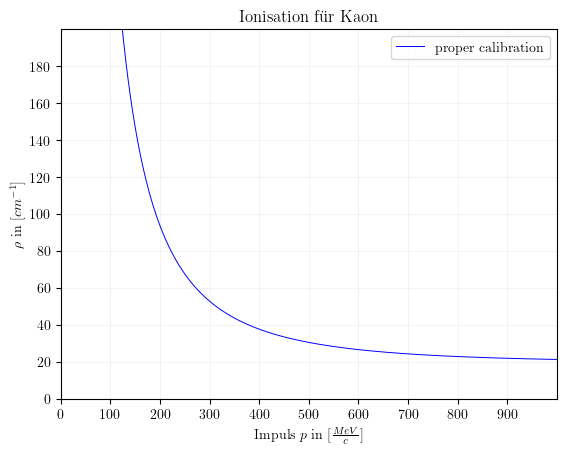

In [46]:
rho_kaon = 52 # placeholder value
rho_kaon = rho_kaon / (4/s_p) # per 4 cm -> per cm; länge mit vergrößerungsfaktor skaliert

momentum_kaon = 810 # in MeV/c
mass_kaon = 493.7 # in MeV/c^2 , same value for rest energy

# beta_kaon = np.sqrt( 1 - ( mass_kaon / (mass_kaon + momentum_kaon) )**2)
beta_kaon = momentum_kaon/np.sqrt(mass_kaon**2 + momentum_kaon**2)
ic(beta_kaon)

# calibrated terms inside the bracket of the bethe bloch formula
cal_bethebloch_log = np.log( (46880 * beta_kaon**2) / (1 - beta_kaon**2) )
cal_bethebloch_logbybeta = cal_bethebloch_log / beta_kaon**2
cal_bethebloch_bracket = cal_bethebloch_logbybeta - 1

calibration_value = rho_kaon / cal_bethebloch_bracket
ic(calibration_value)

def bubbledensity(calibrationfactor, mass, momentum):
    
    # beta = np.sqrt( 1 - ( mass / (mass + momentum) )**2)
    beta = momentum/np.sqrt(mass**2 + momentum**2)
    
    bethebloch_log = np.log( (46880 * beta**2) / (1 - beta**2) )
    bethebloch_logbybeta = bethebloch_log / beta**2
    bethebloch_bracket = bethebloch_logbybeta - 1
    
    return calibrationfactor * bethebloch_bracket 


p = np.linspace(100,1000, 1000)
fig, ax = plt.subplots()
ax.plot(p, bubbledensity(calibration_value, mass_kaon, p), 'b', linewidth=.7, label='proper calibration')
ax.set_title('Ionisation für Kaon')
ax.set_ylim([0, 200]) 
ax.set_xlim([0,1000])
ax.set(xlabel=f'Impuls $p$ in [$\\frac{{MeV}}{{c}}$]', ylabel=f' $\\rho$ in [$cm^{{-1}}$] ')
ax.set_xticks(np.arange(0, 1000, 100))  # X-axis ticks from 0 to 10 with a step of 2
ax.set_yticks(np.arange(0, 200, 20)) 
ax.legend()
ax.grid(True, linewidth=0.5, alpha=0.2)
# plt.savefig("plots/Ionisation Kaon.pdf")
plt.show()

## Gesamtenergie und -impulserhaltung

\begin{align}
    E_{ges} &= E_{K^{-}} + E_{p} = \sqrt{m^{2}_{K^{-}} + \mathbf{p}_{K^{-}}^{2} } + m_{p} 
\end{align}

## Topologien

In [6]:
# Maßstabsetzung, Impuls = 810MeV/c
r_gem1 = 230 # gemessener Krümmungsradius in cm
delta_r_gem1 = 7.5

df1 = parameterset(r_gem1, delta_r_gem1)[4]
df1

,r_gem,delta_r_gem,r_real,delta_r_real,momentum,delta_momentum
1,230,7.5,132.101435,4.311364,811.882212,26.49721


In [7]:
# Folie 223
r_gem1 = 65
delta_r_gem1 = 2.5
theta_1 = -25 # possibly 360 - 25 = 335 

r_gem2 = 80 
delta_r_gem2 = 2.5
theta_2 = 9

r_gem3 = 90
delta_r_gem3 = 2.5
theta_3 = 14

df2 = parameterset(np.array([r_gem1,r_gem2,r_gem3]),np.array([delta_r_gem1,delta_r_gem2,delta_r_gem3,]))[4]
df2

,r_gem,delta_r_gem,r_real,delta_r_real,momentum,delta_momentum
1,65,2.5,37.333014,1.436774,229.444973,8.830268
2,80,2.5,45.948325,1.437231,282.393813,8.833078
3,90,2.5,51.691866,1.437588,317.693039,8.835274


In [8]:
# Folie 229, Topologie 201
r_gem1 = 140
delta_r_gem1 = 5
theta_1 = -25 # possibly 360 - 25 = 335
bubble_1 = np.array([48,47])

r_gem2 = 36
delta_r_gem2 = 2.5
theta_2 = -25 # 335 
bubble_2 = np.array([50,56]) 

r_gem3 = 42.5
delta_r_gem3 = 2.5
theta_3 = 42
bubble_3 = np.array([59,46])

r_gem4 = 33
delta_r_gem4 = 2.5
theta_4 = 57
bubble_4 = np.array([58,61])

df3 = parameterset(np.array([r_gem1,r_gem2,r_gem3,r_gem4]),np.array([delta_r_gem1,delta_r_gem2,delta_r_gem3,delta_r_gem4]))[4]
df3

,r_gem,delta_r_gem,r_real,delta_r_real,momentum,delta_momentum
1,140.0,5.0,80.409569,2.873831,494.189172,17.662280
2,36.0,2.5,20.676746,1.436158,127.077216,8.826482
3,42.5,2.5,24.410048,1.436265,150.021713,8.827142
4,33.0,2.5,18.953684,1.436114,116.487448,8.826215


In [9]:
# Folie 239
r_gem1 = 113
delta_r_gem1 = 5
theta_1 = -30.5
bubble_1 = np.array([54,52])

r_gem2 = 215
delta_r_gem2 = 7.5
theta_2 = 56
bubble_2 = np.array([49,51])


df4 = parameterset(np.array([r_gem1,r_gem2]),np.array([delta_r_gem1,delta_r_gem2]))[4]
df4 

,r_gem,delta_r_gem,r_real,delta_r_real,momentum,delta_momentum
1,113,5.0,64.902010,2.873113,398.881261,17.657866
2,215,7.5,123.486124,4.310896,758.933372,26.494335


In [10]:
# Folie 285
r_gem1 = 54
delta_r_gem1 = 2.5
theta_1 = -58
bubble_1 = np.array([48,50])

df5 = parameterset(np.array([r_gem1]),np.array([delta_r_gem1]))[4]
df5

,r_gem,delta_r_gem,r_real,delta_r_real,momentum,delta_momentum
1,54,2.5,31.01512,1.436499,190.615824,8.828576


In [11]:
# Gesamtdataframe dfs

k=0
firstindex = []
secondindex = []
for df in dfs:
    indexlength = len(df.index)
    # firstindexentry = (np.ones(indexlength) + k).tolist() 
    firstindexentry = (np.ones(indexlength) + k).astype(int).tolist()
    firstindex.extend(firstindexentry) 
    j=0
    for j in range(1, indexlength + 1):
        secondindex.append(j)
    k += 1


total_df = pd.concat(dfs, axis=0)
total_df.index = pd.MultiIndex.from_arrays([firstindex, secondindex], names=["Versuch", "Teilchenspur"])
total_df.columns = [f'r$_{{gem}} [cm]$', f'$\\Delta r_{{gem}} [cm]$', f'$r_{{real}} [cm]$', f'$\\Delta r_{{real}} [cm]$', f'$p [\\frac{{MeV}}{{c}}]$', f'$\\Delta p [\\frac{{MeV}}{{c}}]$']

total_df

# latex_table = total_df.to_latex(
#     index=True, 
#     escape=False,
#     caption="Parameterwerte für die Impulsberechnung mittels Kinematik. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100",
#     label="tab:momentumkinematic", 
#     position="H",  
#     column_format="llrrrrrr", 
#     float_format="{:0.4f}".format)
# print(latex_table)

r$_{gem} [cm]$  $\Delta r_{gem} [cm]$  $r_{real} [cm]$  \
Versuch Teilchenspur                                                           
1       1                      230.0                    7.5       132.101435   
2       1                       65.0                    2.5        37.333014   
        2                       80.0                    2.5        45.948325   
        3                       90.0                    2.5        51.691866   
3       1                      140.0                    5.0        80.409569   
        2                       36.0                    2.5        20.676746   
        3                       42.5                    2.5        24.410048   
        4                       33.0                    2.5        18.953684   
4       1                      113.0                    5.0        64.902010   
        2                      215.0                    7.5       123.486124   
5       1                       54.0                    2.5        31.015120   

                      $\Delta r_{real} [cm]$  $p [\frac{MeV}{c}]$  \
Versuch Teilchenspur                                                
1       1                           4.311364           811.882212   
2       1                           1.436774           229.444973   
        2                           1.437231           282.393813   
        3                           1.437588           317.693039   
3       1                           2.873831           494.189172   
        2                           1.436158           127.077216   
        3                           1.436265           150.021713   
        4                           1.436114           116.487448   
4       1                           2.873113           398.881261   
        2                           4.310896           758.933372   
5       1                           1.436499           190.615824   

                      $\Delta p [\frac{MeV}{c}]$  
Versuch Teilchenspur                              
1       1                              26.497210  
2       1                               8.830268  
        2                               8.833078  
        3                               8.835274  
3       1                              17.662280  
        2                               8.826482  
        3                               8.827142  
        4                               8.826215  
4       1                              17.657866  
        2                              26.494335  
5       1                               8.828576

## Gesamttabelle
Spur: Ladung, Krümmungsradius, Streuwinkel, Impuls, Impulskomponenten, Energien und Bläschendichte (Anleitung S. 21)